# Project: Natural Language Processing and the Web

## **Open-Domain Deception Detection**





In [1]:
import pandas as pd
import numpy as np
import scattertext as st
import spacy

from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
assert st.__version__ >= '0.0.2.25'

### **Truth and Lies Data set**

#### Dataset consists of labelled text of truth and lies.

#### Dataset is from https://web.eecs.umich.edu/~mihalcea/downloads.html#OpenDeception



In [3]:
rdf = pd.read_csv('train.txt', sep='\t')
rdf['label'] = rdf['label'].apply(lambda x : {'lie': 'Negative', 'truth': 'Positive'}[x])
print(rdf.label.value_counts())

Negative    1811
Positive    1773
Name: label, dtype: int64


In [4]:
corpus = (st.CorpusFromPandas(rdf, 
                              category_col='label', 
                              text_col='text',
                              nlp = st.whitespace_nlp_with_sentences)
          .build())
corpus.get_term_freq_df().to_csv('term_freqs.csv')
unigram_corpus = corpus.get_unigram_corpus()

### **Visualization of the corpus using Scattertext**

#### The x-axis indicates the rank of a word or bigram in the set of positive (truth) labels, and the y-axis represents negative (lie) labels.

#### Ranks are determined using the "dense" ranking, meaning the most frequent terms, regardless of ties, are given rank 1, the next most frequent terms, regardless of ties, are given rank 2, and so on.

#### Scattertext selectively labels points in such a way as to prevent labels from overlapping other elements of the graph. 


In [5]:
html = st.produce_scattertext_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    sort_by_dist=False,
    term_scorer=st.RankDifference(),
    transform=st.Scalers.percentile_dense
)
file_name = 'lies_truth_detection.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

/home/nana/anaconda3/envs/nlp/lib/python3.6/site-packages/scattertext/frequencyreaders/DefaultBackgroundFrequencies.py:30: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  names=['word', 'background'])


In [6]:
html = st.produce_scattertext_explorer(
    corpus,
    category='Positive',
    not_categories=['Negative'],
    sort_by_dist=False,
    term_scorer=st.RankDifference(),
)
file_name = 'lies_truth_analyzing.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)


/home/nana/anaconda3/envs/nlp/lib/python3.6/site-packages/scattertext/frequencyreaders/DefaultBackgroundFrequencies.py:30: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  names=['word', 'background'])


### **Scaled F-Score**

In [7]:
from scipy.stats import hmean

term_freq_df = corpus.get_unigram_corpus().get_term_freq_df()[['Positive freq', 'Negative freq']]
term_freq_df = term_freq_df[term_freq_df.sum(axis=1) > 0]

term_freq_df['pos_precision'] = (term_freq_df['Positive freq'] * 1./
                                 (term_freq_df['Positive freq'] + term_freq_df['Negative freq']))

term_freq_df['pos_freq_pct'] = (term_freq_df['Positive freq'] * 1.
                                /term_freq_df['Positive freq'].sum())

term_freq_df['pos_hmean'] = (term_freq_df
                             .apply(lambda x: (hmean([x['pos_precision'], x['pos_freq_pct']])
                                               if x['pos_precision'] > 0 and x['pos_freq_pct'] > 0 
                                               else 0), axis=1))
# term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

In [8]:
term_freq_df.pos_freq_pct.describe()

count    5282.000000
mean        0.000189
std         0.001359
min         0.000000
25%         0.000000
50%         0.000069
75%         0.000138
max         0.050526
Name: pos_freq_pct, dtype: float64

In [9]:
term_freq_df.pos_precision.describe()

count    5282.000000
mean        0.489611
std         0.421531
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: pos_precision, dtype: float64

In [10]:
freq = term_freq_df.pos_freq_pct.values
prec = term_freq_df.pos_precision.values
html = st.produce_scattertext_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    
    x_label = 'Portion of words used in positive reviews',
    original_x = freq,
    x_coords = (freq - freq.min())/freq.max(),
    x_axis_values = [int(freq.min()*1000)/1000., 
                     int(freq.max() * 1000)/1000.],
    
    y_label = 'Portion of documents containing word that are positive',    
    original_y = prec,
    y_coords = (prec - prec.min())/prec.max(),
    y_axis_values = [int(prec.min() * 1000)/1000., 
                     int((prec.max()/2.)*1000)/1000., 
                     int(prec.max() * 1000)/1000.],
    scores = term_freq_df.pos_hmean.values,
    
    sort_by_dist=False,
    show_characteristic=False
)
file_name = 'not_normed_freq_prec.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

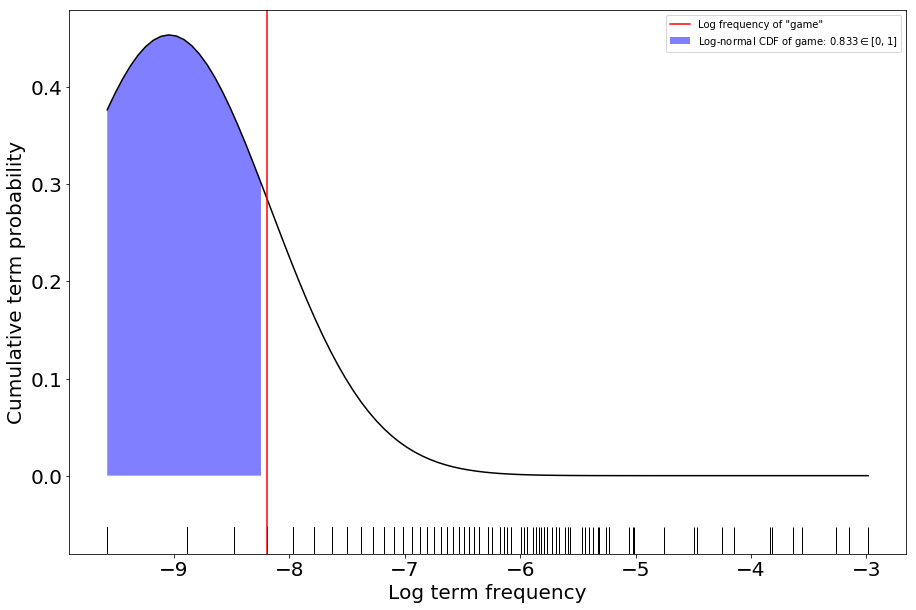

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(15,10))
freqs = term_freq_df.pos_freq_pct[term_freq_df.pos_freq_pct > 0]
log_freqs = np.log(freqs)

sns.distplot(log_freqs[:1000], kde=False, rug=True, hist=False, rug_kws={"color": "k"})

x = np.linspace(log_freqs.min(), 
                log_freqs.max(), 
                100)
frozen_norm = norm(log_freqs.mean(), log_freqs.std())
y = frozen_norm.pdf(x)
plt.plot(x, y ,color='k')
term = 'game'
word_freq = log_freqs.loc[term]
term_cdf = frozen_norm.cdf(word_freq)
plt.axvline(x=word_freq, color='red', label='Log frequency of "'+term+'"')
plt.fill_between(x[x < word_freq], 
                 y[x < word_freq], y[x < word_freq] * 0, 
                 facecolor='blue', 
                 alpha=0.5,
                 label="Log-normal CDF of %s: $%0.3f \in [0,1]$" % (term, term_cdf) )
ax.set_xlabel('Log term frequency')
ax.set_ylabel('Cumulative term probability')
plt.legend()
for item in ([ax.title,  ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() ):
    item.set_fontsize(20)
plt.rc('legend', fontsize=20)     
plt.show()

In [12]:
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std ())

term_freq_df['pos_precision_normcdf'] = normcdf(term_freq_df.pos_precision)

term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df.pos_freq_pct.values)

term_freq_df['pos_scaled_f_score'] = hmean([term_freq_df['pos_precision_normcdf'], term_freq_df['pos_freq_pct_normcdf']])

#term_freq_df.sort_values(by='pos_scaled_f_score', ascending=False).iloc[:10]

In [13]:
freq = term_freq_df.pos_freq_pct_normcdf.values
prec = term_freq_df.pos_precision_normcdf.values
html = st.produce_scattertext_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    
    x_label = 'Portion of words used in positive reviews (norm-cdf)',
    original_x = freq,
    x_coords = (freq - freq.min())/freq.max(),
    x_axis_values = [int(freq.min()*1000)/1000., 
                     int(freq.max() * 1000)/1000.],
    
    y_label = 'documents containing word that are positive (norm-cdf)',    
    original_y = prec,
    y_coords = (prec - prec.min())/prec.max(),
    y_axis_values = [int(prec.min() * 1000)/1000., 
                     int((prec.max()/2.)*1000)/1000., 
                     int(prec.max() * 1000)/1000.],
    scores = term_freq_df.pos_scaled_f_score.values,
    
    sort_by_dist=False,
    show_characteristic=False
)
file_name = 'normed_freq_prec.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

/home/nana/anaconda3/envs/nlp/lib/python3.6/site-packages/scattertext/frequencyreaders/DefaultBackgroundFrequencies.py:30: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  names=['word', 'background'])


In [14]:
term_freq_df['neg_precision_normcdf'] = normcdf((term_freq_df['Negative freq'] * 1./
                                 (term_freq_df['Negative freq'] + term_freq_df['Positive freq'])))

term_freq_df['neg_freq_pct_normcdf'] = normcdf((term_freq_df['Negative freq'] * 1.
                                /term_freq_df['Negative freq'].sum()))

term_freq_df['neg_scaled_f_score'] = hmean([term_freq_df['neg_precision_normcdf'],  term_freq_df['neg_freq_pct_normcdf']])

term_freq_df['scaled_f_score'] = 0
term_freq_df.loc[term_freq_df['pos_scaled_f_score'] > term_freq_df['neg_scaled_f_score'], 
                 'scaled_f_score'] = term_freq_df['pos_scaled_f_score']
term_freq_df.loc[term_freq_df['pos_scaled_f_score'] < term_freq_df['neg_scaled_f_score'], 
                 'scaled_f_score'] = 1-term_freq_df['neg_scaled_f_score']
term_freq_df['scaled_f_score'] = 2 * (term_freq_df['scaled_f_score'] - 0.5)
#term_freq_df.sort_values(by='scaled_f_score', ascending=False).iloc[:10]

In [15]:
is_pos = term_freq_df.pos_scaled_f_score > term_freq_df.neg_scaled_f_score
freq = term_freq_df.pos_freq_pct_normcdf*is_pos - term_freq_df.neg_freq_pct_normcdf*~is_pos
prec = term_freq_df.pos_precision_normcdf*is_pos - term_freq_df.neg_precision_normcdf*~is_pos
def scale(ar): 
    return (ar - ar.min())/(ar.max() - ar.min())
def close_gap(ar): 
    ar[ar > 0] -= ar[ar > 0].min()
    ar[ar < 0] -= ar[ar < 0].max()
    return ar

html = st.produce_scattertext_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    
    x_label = 'Frequency',
    original_x = freq,
    x_coords = scale(close_gap(freq)),
    x_axis_labels = ['Frequent in Neg', 
                     'Not Frequent', 
                     'Frequent in Pos'],
    
    y_label = 'Precision',    
    original_y = prec,
    y_coords = scale(close_gap(prec)),
    y_axis_labels = ['Neg Precise', 
                     'Imprecise', 
                     'Pos Precise'],
    
    
    scores = (term_freq_df.scaled_f_score.values + 1)/2,
    sort_by_dist=False,
    show_characteristic=False
)
file_name = 'sfs_explain.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)

In [16]:
html = st.produce_frequency_explorer(
    corpus.remove_terms(set(corpus.get_terms()) - set(term_freq_df.index)),
    category='Positive',
    not_category_name='Negative',
    not_categories=['Negative'],
    term_scorer=st.ScaledFScorePresets(beta=1, one_to_neg_one=True),
    grey_threshold=0
)
file_name = 'freq_sfs.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1300, height=700)